In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings("ignore")

from time import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
import matplotlib.ticker as tkr
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import math
#import keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df=pd.read_csv("household_power_consumption.txt",delimiter=";")
print(df.shape)
df.head()

(2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [3]:
df["date_time"]=pd.to_datetime(df['Date'] + ' ' + df['Time'])

In [4]:
df['Global_active_power']=pd.to_numeric(df['Global_active_power'],errors='coerce')
df = df.dropna(subset=['Global_active_power'])
df['date_time']=pd.to_datetime(df['date_time'])
df['year']=df['date_time'].apply(lambda x : x.year)
df['quarter']=df['date_time'].apply(lambda x : x.quarter)
df['month']=df['date_time'].apply(lambda x : x.month)
df['day']=df['date_time'].apply(lambda x: x.day)
df = df.loc[:,['date_time','Global_active_power','year','quarter','month','day']]
df.sort_values('date_time',inplace=True,ascending=True)
df.head()

,date_time,Global_active_power,year,quarter,month,day
0,2006-12-16 17:24:00,4.2160,2006,4,12,16
1,2006-12-16 17:25:00,5.3600,2006,4,12,16
2,2006-12-16 17:26:00,5.3740,2006,4,12,16
3,2006-12-16 17:27:00,5.3880,2006,4,12,16
4,2006-12-16 17:28:00,3.6660,2006,4,12,16


In [5]:
df = df.reset_index(drop=True)
df.head()

,date_time,Global_active_power,year,quarter,month,day
0,2006-12-16 17:24:00,4.2160,2006,4,12,16
1,2006-12-16 17:25:00,5.3600,2006,4,12,16
2,2006-12-16 17:26:00,5.3740,2006,4,12,16
3,2006-12-16 17:27:00,5.3880,2006,4,12,16
4,2006-12-16 17:28:00,3.6660,2006,4,12,16


In [6]:
df['weekday'] = df.apply(lambda row: row['date_time'].weekday(),axis=1)
df['weekday']= (df['weekday']<5).astype(int)
print(df.shape)
print(df['date_time'].min())
print(df['date_time'].max())
df.head()

(2049280, 7)
2006-12-16 17:24:00
2010-12-11 23:59:00


,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0


In [7]:
df = df.query('year != 2006')

In [8]:
stat,p =stats.normaltest(df['Global_active_power'])
alpha = 0.05
print("H0: Data comes from a Gaussian Distribution")
print("HA: Data differs from a Gaussian Distribution")
print("\n")
if p > alpha:
    print("Data looks Gaussian (Fail to reject H0)")
else:
    print("Reject H0, Dats doesn't look like a gaussian")

H0: Data comes from a Gaussian Distribution
HA: Data differs from a Gaussian Distribution


Reject H0, Dats doesn't look like a gaussian


The above normal test is Agostino K^2 test 

Kurtosis : 4.3052725040377915
Skewness : 1.7991280902218618


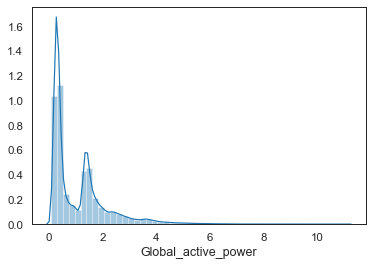

In [9]:
sns.distplot(df['Global_active_power'])
print("Kurtosis : {}".format(stats.kurtosis(df['Global_active_power'])))
print("Skewness : {}".format(stats.skew(df['Global_active_power'])))

### Kurtosis > 0, therefore the distribution has a heavy tail
### Skew => [-0.5,0.5] fairly symmetrical
#### Skew => [(-1,-0.5),(0.5,1)] moderately assymmetrical
#### Skew =>[<-1,>1] highly assymetrical

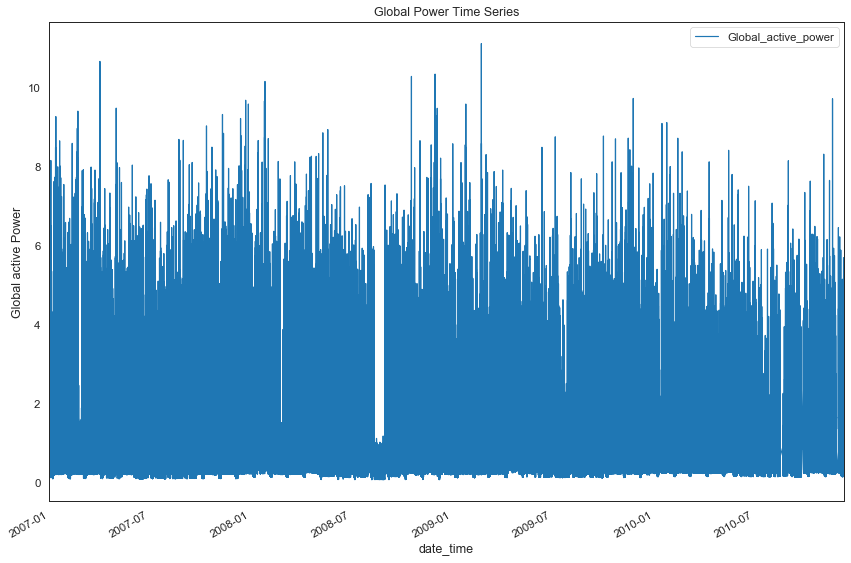

In [10]:
df1=df.loc[:,['date_time','Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,8))
plt.ylabel("Global active Power")
plt.title("Global Power Time Series")
plt.tight_layout()
plt.show()

This plot doesn't give us any insights

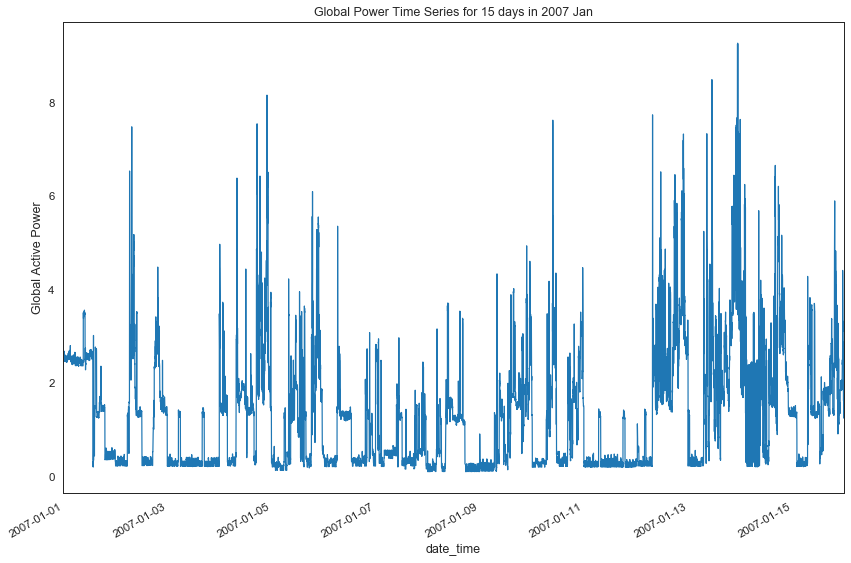

In [11]:
df2 = df1[(df1.index>='2007-01-01') & (df1.index < '2007-01-16')]
df2.plot(figsize=(12,8))
plt.legend().set_visible(False)
plt.ylabel("Global Active Power")
plt.title("Global Power Time Series for 15 days in 2007 Jan")
plt.tight_layout()
plt.show()

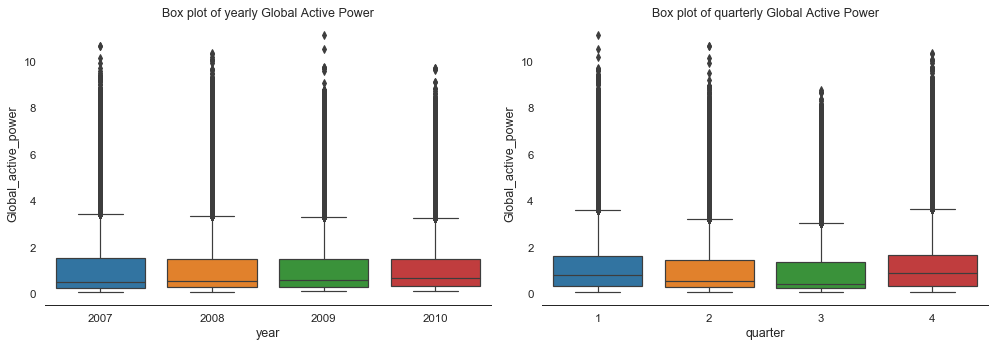

In [12]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x='year',y='Global_active_power',data=df)
# plt.xlabel('year')
# plt.ylabel('Global_active_power')
plt.title("Box plot of yearly Global Active Power")
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x='quarter',y='Global_active_power',data=df)
# plt.xlabel('year')
# plt.ylabel('Global_active_power')
plt.title("Box plot of quarterly Global Active Power")
sns.despine(left=True)
plt.tight_layout()

Let's compare global active power over the years, they all look quite similar. 
About the quarterly global active power consumption, the median power consumed is higher in the 1st and 4th quarter(winter) and lower in the 2nd and 3rd quarter. 

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2027288.0000,1.0828,1.0493,0.0760,0.3080,0.5940,1.5200,11.1220


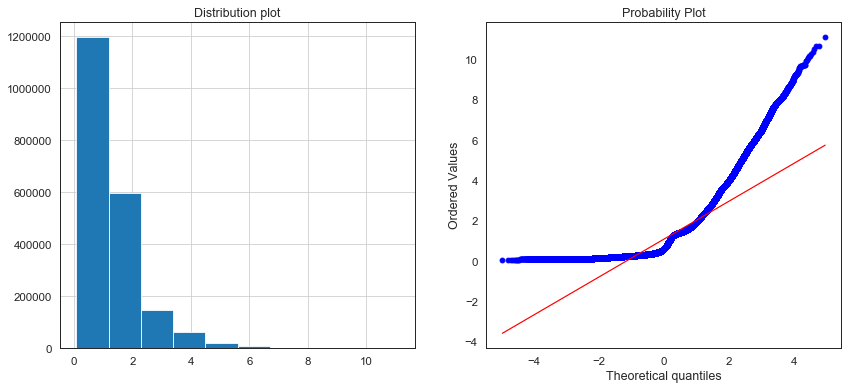

In [13]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist()
plt.title('Distribution plot')

plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'],plot=plt)
df1.describe().T

From the probably plot it can be confirmed that the Global active power distribution varies greatly from normal distribution

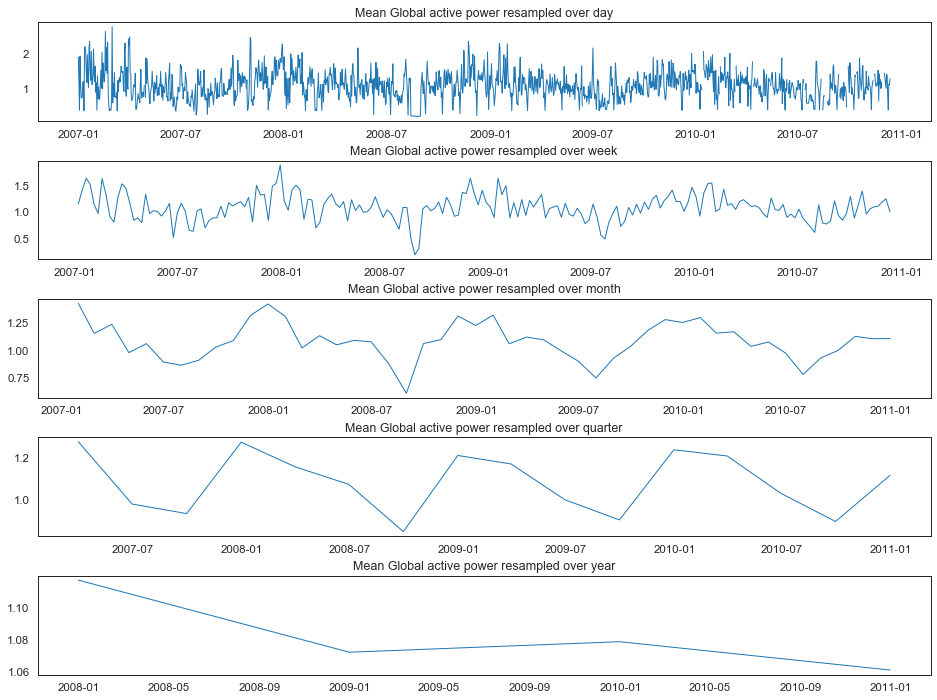

In [14]:
fig = plt.figure(figsize=(16,12))
fig.subplots_adjust(hspace=0.4)
#fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
#ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both',which='major')

ax2 = fig.add_subplot(5,1,2)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both',which='major')

ax3 = fig.add_subplot(5,1,3)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both',which='major')

ax4 = fig.add_subplot(5,1,4)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both',which='major')

ax5 = fig.add_subplot(5,1,5)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both',which='major')

In general, our time series does not have a general upward or downward trend. The highest average power consumption was prior to 2008, it decreased significantly in one year, and has been steady since then.

### Plot by grouping year, quarter, month, day using mean values

Text(0.5, 1.0, 'Mean Global active power by Day')

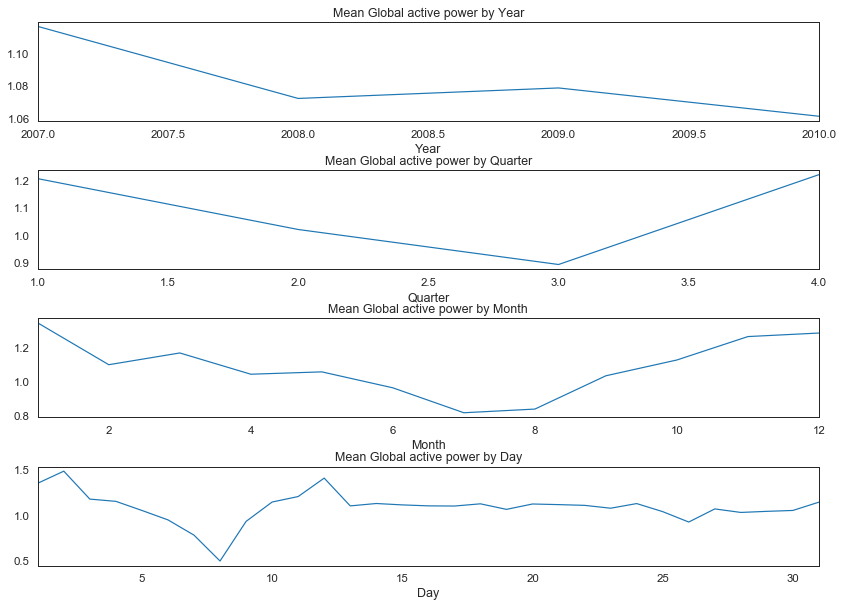

In [15]:
plt.figure(figsize=(14,10))
plt.subplots_adjust(hspace=0.5)

plt.subplot(4,1,1)
df.groupby('year')['Global_active_power'].agg('mean').plot()
plt.xlabel('Year')
plt.title('Mean Global active power by Year')

plt.subplot(4,1,2)
df.groupby('quarter')['Global_active_power'].agg('mean').plot()
plt.xlabel('Quarter')
plt.title('Mean Global active power by Quarter')

plt.subplot(4,1,3)
df.groupby('month')['Global_active_power'].agg('mean').plot()
plt.xlabel('Month')
plt.title('Mean Global active power by Month')

plt.subplot(4,1,4)
df.groupby('day')['Global_active_power'].agg('mean').plot()
plt.xlabel('Day')
plt.title('Mean Global active power by Day')

The above plots have confirmed the previous findings

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c4f73c6a0>,
      dtype=object)

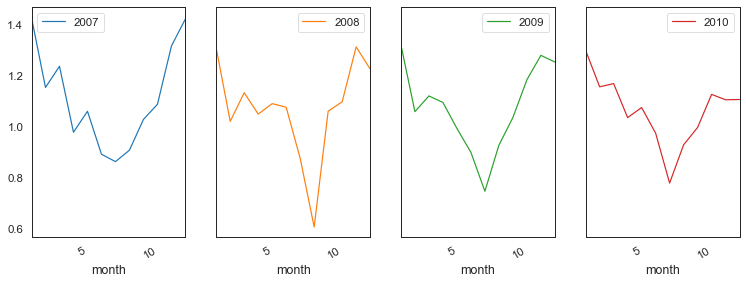

In [16]:
pd.pivot_table(df, values='Global_active_power', columns='year',index='month').plot(subplots=True, 
                                                                                   figsize=(16,16),sharey=True,
                                                                                    layout=(3,5))

Global active power consumption by weekday vs weekend

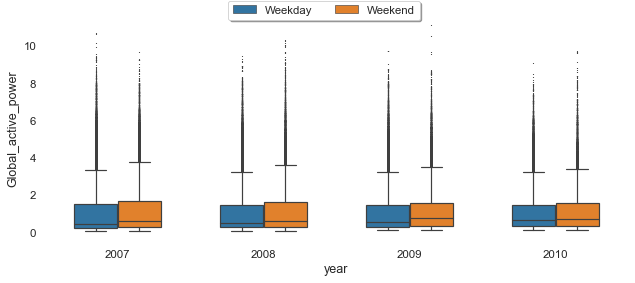

In [17]:
dic={0: 'Weekend',1:'Weekday'}
df['Day']=df['weekday'].map(dic)
a=plt.figure(figsize=(9,4))
plt1=sns.boxplot('year','Global_active_power',hue='Day',width=0.6,fliersize=0.3,data=df)
a.legend(loc='upper center', bbox_to_anchor=(0.5,1.00),shadow=True,ncol=2)
sns.despine(left=True,bottom=True)
#plt.label(' ')
plt.tight_layout()
plt.legend().set_visible(False)

The median global active power in weekdays seems to be lower than the weekends prior to 2010.

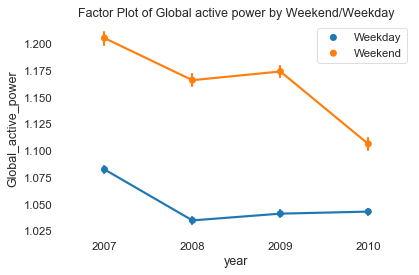

In [18]:
plt1=sns.factorplot('year','Global_active_power',hue='Day',data=df,size=4,aspect=1.5,legend=False)
plt.title('Factor Plot of Global active power by Weekend/Weekday')
plt.tight_layout()
sns.despine(left=True,bottom=True)
plt.legend(loc='upper right')

In [19]:
df2=df1.resample('D',how=np.mean)
def test_stattionarity(timeseries):
    rollmean = timeseries.rolling(window=30).mean()
    rollstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rollmean,color='red',label='Rolling Mean')
    std=plt.plot(rollstd,color='black',label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print(" Result of Augmented Dicky Fuller Test ") 
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'p value','#Lags','#Observations'])
    for k,v in dftest[4].items():
        dfoutput['Critical value %s'%k]=v
    print(dfoutput)

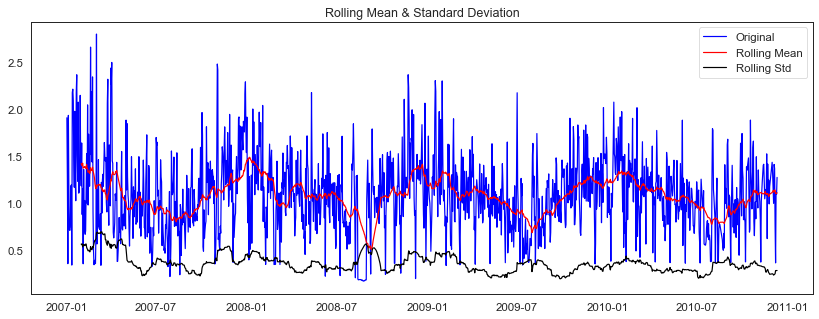

 Result of Augmented Dicky Fuller Test 
Test Statistic         -8.0891
p value                 0.0000
#Lags                   9.0000
#Observations        1407.0000
Critical value 1%      -3.4350
Critical value 5%      -2.8636
Critical value 10%     -2.5679
dtype: float64


In [20]:
test_stattionarity(df2['Global_active_power'].dropna())

### LSTM
The task here will be to predict values for a timeseries given the history of 2 million minutes of a household's power consumption. We are going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

If you want to reduce the computation time, and also get a quick result to test the model, you may want to resample the data over hour. I will keep it is in minutes.

Create dataset, normalize the dataset, split into training and test sets, convert an array of values into a dataset matrix

In [21]:
dataset= df.Global_active_power.values
dataset= dataset.astype('float32')
dataset=np.reshape(dataset, (-1, 1))
scaler= MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)
train_size=int(len(dataset)*0.80)
test_size=len(dataset)-train_size
train, test = dataset[0:train_size,:],dataset[train_size:len(dataset),:]

In [22]:
def create_dataset(series,lookback=1):
    X,Y=[],[]
    for i in range(len(series)-lookback-1):
        a=series[i:(i+lookback),0]
        X.append(a)
        Y.append(series[[i+lookback],0])
    return np.array(X),np.array(Y)

In [23]:
lookback=30
X_train, Y_train = create_dataset(train,lookback)
X_test, Y_test = create_dataset(test, lookback)

In [24]:
X_train.shape

(1621799, 30)

In [25]:
Y_train.shape

(1621799, 1)

In [26]:
# reshape the input as (samples,time_steps,features)
X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
X_train.shape

(1621799, 1, 30)

### Model Architecture

In [27]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train,Y_train,epochs=20,batch_size=70, validation_data=(X_test,Y_test),shuffle=False,verbose=1,
                   callbacks=[EarlyStopping(monitor='val_loss',patience=10)])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 1621799 samples, validate on 405427 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
1621799/1621799 [==============================] - 224s 138us/sample - loss: 7.3275e-04 - val_loss: 4.2363e-04
Epoch 2/20
1621799/1621799 [==============================] - 225s 139us/sample - loss: 6.4363e-04 - val_loss: 4.2710e-04
Epoch 3/20
1621799/1621799 [==============================] - 210s 129us/sample - loss: 6.3610e-04 - val_loss: 4.2890e-04
Epoch 4/20
1621799/1621799 [==============================] - 210s 130us/sample - loss: 6.2793e-04 - val_loss: 4.2819e-04
Epoch 5/20
1621799/1621799 [==============================] - 219s 135us/sample - loss: 6.2487e-04 - val_loss: 4.3369e-04
Epoch 6/20
1621799/1621799 [==============================] - 222s 137us/sample - loss: 6.2150e-04 - val_loss: 4.3378e-04
Epo

In [32]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [35]:
Y_test.shape

(405427, 1)

In [40]:
Y_train.shape

(1621799, 1)

In [41]:
X_train.shape

(1621799, 1, 30)

In [42]:
train_predict.shape

(1621799, 1)

In [47]:
#invert predictions

train_predict=scaler.inverse_transform(train_predict)
#reshape to transpose dimensions using (1,-1)
Y_train= scaler.inverse_transform(Y_train.reshape(1,-1))
test_predict=scaler.inverse_transform(test_predict)
Y_test= scaler.inverse_transform(Y_test.reshape(1,-1))

print("Train Mean Absolute Error: ",mean_absolute_error(Y_train[0],train_predict[:,0]))
print("Train Root Mean Square Error : ",np.sqrt(mean_squared_error(Y_train[0],train_predict[:,0])))

print("==================================================")

print("Test Mean Absolute Error: ",mean_absolute_error(Y_test[0],test_predict[:,0]))
print("Test Root Mean Square Error : ",np.sqrt(mean_squared_error(Y_test[0],test_predict[:,0])))

Train Mean Absolute Error:  213023230.0
Train Root Mean Square Error :  292914800.0
Test Mean Absolute Error:  165915.02
Test Root Mean Square Error :  406126.6


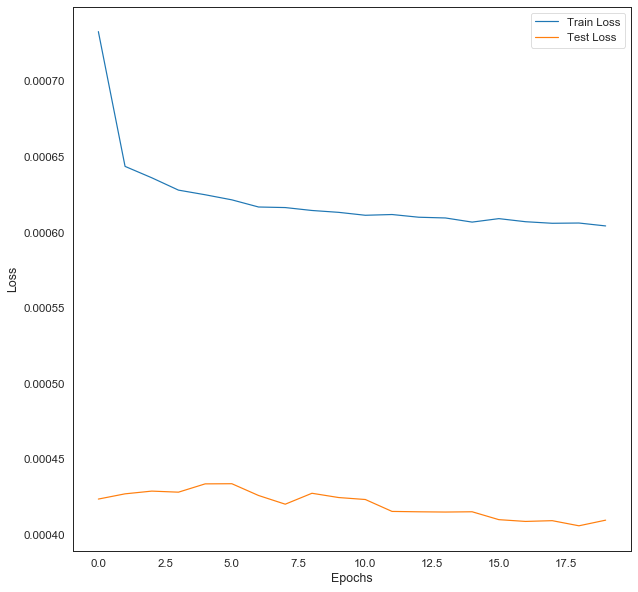

In [49]:
# Plotting Loss
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

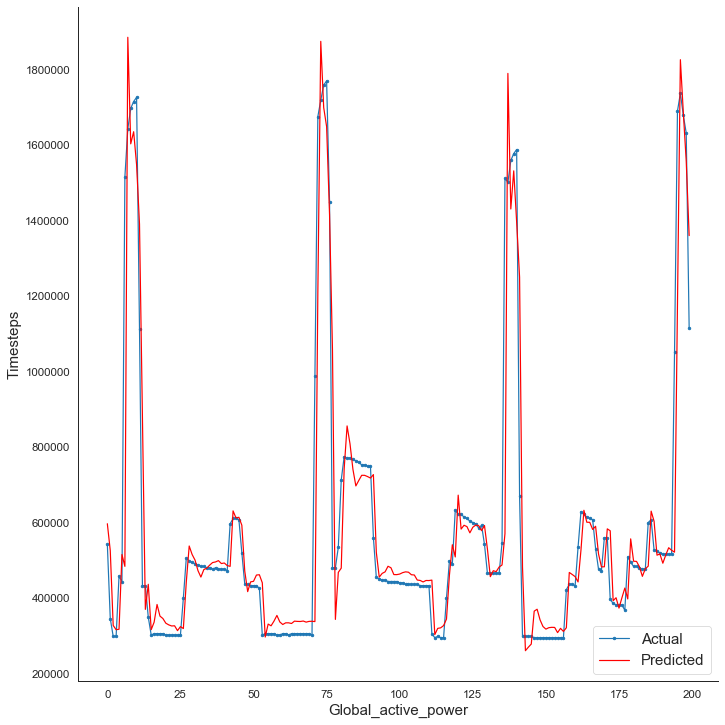

In [53]:
#Plotting the actual and predicted values for 200 timesteps for better visualisation
Y_test=Y_test.reshape(-1,1)
Y_train=Y_train.reshape(-1,1)
timestep = [x for x in range(200)]
plt.figure(figsize=(10,10))
plt.plot(timestep,Y_test[0:200],marker='.',label='Actual')
plt.plot(timestep,test_predict[0:200],'r', label='Predicted')
plt.tight_layout()
sns.despine(top=True)
plt.xlabel("Global_active_power",size=15)
plt.ylabel("Timesteps",size=15)
plt.legend(fontsize=15)
plt.show()

## Conclusion
It looks similar in most areas, we could therefore say that our model is working pretty well and predicted almost accurate results.